In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup
import midi
from midi import generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init()

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 10.0 0.5
 >> Context(max_t=2.0, dt=0.05, n_timesteps=40, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  40.000000
 max_f: 10.000000, min_f: 0.500000


In [5]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.MIDIFILE # GLOBAL
dn = 'drum_midi/'
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, dirname=dn, multiTrack=multiTrack, r=True)


Importing midi-data

Encoding midi-data
 500
> -> multi-track = True MidiFile
 [INFO] : 
 |  True


In [8]:
# n = 1000
# min_f = 0
# max_f = 3
# x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
#     n_polyrythms=1,
#     n_channels=3,
#     d_phase=True,
#     return_params=True,
#     dim4=dim4,
#     multiTrack=multiTrack)

In [9]:
x_train.shape

(500, 40, 9, 1)

In [10]:
m = int(x_train.shape[0] * 0.9)
x_train.shape, m

((500, 40, 9, 1), 450)

In [11]:
x_test = x_train[m:]
x_train = x_train[:m]

m (40, 9)


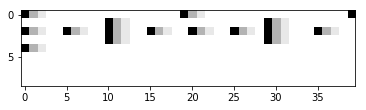

m (40, 9)


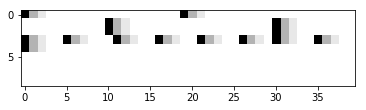

["../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"]

In [12]:
plot.single(x_train[0, :50,:,0])
plot.single(x_train[1, :50,:,0])
# plot.single(x_train[2, :50,:,0])
labels[0:4]

In [13]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(40, 9, 1)

In [329]:
latent_dim = 3
intermediate_dim = 128
epsilon_std = 1.0

In [789]:
def sub_encoder(input_shape=(10,3,1), latent_dim=2):
    sub_encoder_input = Input(shape=input_shape)
    h = sub_encoder_input
    
    timesteps, notes, channels = input_shape
    
    # Convolution
    k = (2,1)
    s = (2,1)
#     h = Conv2D(32, kernel_size=k, strides=1, activation='relu', padding='valid')(h)
    h = Conv2D(64, kernel_size=k, strides=s, activation='relu', padding='valid')(h)
    h = Conv2D(128, kernel_size=k, strides=s, activation='relu', padding='valid')(h)

#     # input per note
#     note_list = Permute([2,1,3], name='input_per_note')(h)
    
#     rnn = SimpleRNN(128, name='rnn_per_note')
#     reshape = Reshape((128,1))

#     n_capsules = 10
#     capsule_dim = 6
#     n_routings=3
#     share_weights=True
#     capsule = Capsule(n_capsules, capsule_dim, n_routings, share_weights)

#     x = Lambda(lambda layer: capsule(reshape(rnn(layer))) )
#     h_per_note = TimeDistributed(x, name='TimeDistributed_per_note')(note_list)
#     shape = K.int_shape(h_per_note)[1:]
#     h_per_note = Reshape( [notes, np.prod(shape[1:3])] )(h_per_note)
#     h_per_note = Flatten()(h_per_note)

#     # 'global' input
#     h = encoder_input
#     h = Reshape(input_shape[:-1])(h)
#     h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
#     h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='valid')(h)
#     h = Conv1D(128, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
#     # old layers
# #     h = Conv2D(1, kernel_size=k, strides=1, activation='relu', padding='valid')(h)
# #     shape = K.int_shape(h)[1:]
# #     h = Reshape(shape[0:2])(h) # (reduced_timesteps, notes)
# #     h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
#     h = SimpleRNN(128)(h)
# #     h = LSTM(256)(h)
# #     h = Bidirectional(LSTM(256)(h))
#     h_global = h
    
#     h = Reshape((-1,1))(h_global) # h_global h_per_note
# #     h = Concatenate(axis=1)([h_global, h_per_note])

# #     h = Reshape((-1,1))(h)
    
#     n_capsules = 10
#     capsule_dim = 6
#     n_routings=3
#     share_weights=True
#     h = Capsule(n_capsules, capsule_dim, n_routings, share_weights)(h)   
    h = Flatten()(h)
    h = Dense(100)(h)
    
    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
    z_mean = Reshape((1, latent_dim))(z_mean)
    z_log_var = Reshape((1, latent_dim))(z_log_var)
    h = Concatenate(axis=1)([z_mean, z_log_var])

    sub_encoder_output = h
    sub_encoder_model = Model(sub_encoder_input, sub_encoder_output, name='sub_encoder_model-')
    sub_encoder_mean = Model(sub_encoder_input, z_mean, name='sub_encoder_mean')
#     print('Extra params:', [k.count_params() for k in [rnn, reshape, capsule]])
    return sub_encoder_model, sub_encoder_mean

class Resample(keras.layers.Layer):
    def __new__(self, input_shape, length):
        timesteps, notes, channels = input_shape
        n = int(timesteps/length)
        # TODO crop input if incompatible dims
        # crop((0, timesteps % length))
        return Reshape((n, length, notes, channels))

# def resample(input_shape, length):
#     timesteps, notes, channels = input_shape
#     n = int(timesteps/length)
#     # TODO crop input if incompatible dims
#     # crop((0, timesteps % length))
#     return Reshape((n, length, notes, channels))

# def split_input_samples(x, input_shape, length):

def encoder(encoder_input, sub_encoder):
    """ An existing sub_model can be used to return for example just the mean of the 
    latent-coordinates
    """
    h = Resample(input_shape, length)(encoder_input)
    h = TimeDistributed(sub_encoder)(h)
    encoder_output = h
    return Model(encoder_input, encoder_output, name='encoder_model-')

def new_encoder(input_shape, latent_dim=2, length=10):
    """ Create an encoder that encodes a batch of images into a batch of the mean + variance
    of the corresponding latent-coordinates
    """
    encoder_input = Input(shape=input_shape)
    timesteps, notes, channels = input_shape
    sub_shape = (length, notes, channels)
    sub_encoder_model, sub_encoder_mean = sub_encoder(sub_shape, latent_dim) 
    # output_shape  = ([mean], [var])
    model = encoder(encoder_input, sub_encoder_model)
    # output_shape = (batch_size, latent_samples, 2, latent_dim)
    m = (model, sub_encoder_model, sub_encoder_mean)
    return m, encoder_input, encoder_output

In [790]:
latent_samples = 4
length = int(timesteps/latent_samples)
models_, encoder_input, encoder_output = new_encoder(input_shape, latent_dim, length)
encoder_model, sub_encoder_model, sub_encoder_mean = models_
sub_encoder_model.summary()
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_109 (InputLayer)          (None, 10, 9, 1)     0                                            
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 5, 9, 64)     192         input_109[0][0]                  
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 2, 9, 128)    16512       conv2d_85[0][0]                  
__________________________________________________________________________________________________
flatten_55 (Flatten)            (None, 2304)         0           conv2d_86[0][0]                  
__________________________________________________________________________________________________
dense_135 

In [791]:
def sample(z_mean, z_log_var, latent_dim=2, epsilon_std=1.):
    epsilon = K.random_normal(
        shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

   
def sampleSequence(latent_dim=2., epsilon_std=1.):
    # iterate batch_samples, in this case this is equal to iterating the latent_samples 
    # map_fn(fn, values) -> [values.shape[0]] + fn(values[0]).shape
    return lambda layers: K.map_fn(lambda args: sample(args[:,0], args[:,1], latent_dim, epsilon_std), layers)

In [792]:
# sample_ = lambda layers: K.map_fn(lambda args: sample(args, latent_dim, epsilon_std), layers)
# sample_ = lambda args: sample(args, latent_dim, epsilon_std)

In [793]:
z_input = encoder_model(encoder_input)
# z = Lambda(sample_)
# f = Lambda(lambda x: x[:1] , )
sample_ = sampleSequence(latent_dim, epsilon_std)
z_output = Lambda(sample_, name='sample_z-')(z_input)

In [794]:
K.int_shape(z_input)

(None, 4, 2, 3)

In [795]:
K.int_shape(z_output)

(None, 4, 3)

In [796]:
K.shape(z_input)

<tf.Tensor 'Shape_49:0' shape=(4,) dtype=int32>

In [797]:
def list_sub_decoders(output_shape):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_shape
    filters = 64
#     output_shape = (14, 14, filters)
#     output_shape = (timesteps, notes, 1)
    
    # keras.examples.variational_autoencoder_deconv.py
    decoders = []
    decoders += [ Dense(100) ]
    decoders += [ LeakyReLU(alpha=0.3) ]
    
#     # add a bypass layer
#     w = 256
#     decoders += [ Dense(w, activation='relu') ]
#     extra_decoders = []
#     for _ in range(3):
#         extra_decoders += [ Dense(w, activation='elu', bias_initializer='zeros') ]

#     extra_d = Lambda(lambda layer: utils.composition(extra_decoders, layer))
#     decoders += [ Lambda(lambda layer: Add()([layer, extra_d(layer)])) ]
    
#     decoders += [ BatchNormalization(momentum=0.5) ]

#     # Shared Layers (Conductor)
    
#     # +1 is used to produce an extra input for the first embedding-decoder    
#     dim1, dim2, filters = 4+1, int(timesteps/4), notes*4
#     print('dim1: %i dim2: %i filters: %i' % (dim1, dim2, filters))
#     decoders += [ Dense(dim1*dim2, activation='tanh', name='conductor') ] # stddev = 0.001 in musicVAE
#     decoders += [ BatchNormalization(momentum=0.3) ]
    
#     decoders += [ Reshape((dim1, dim2, 1)) ]
#     # TODO CudnnLSTM to run on gpu
#     conductor_lstm = LSTM(filters, return_sequences=True) # dropout = ..
#     decoders += [ TimeDistributed(conductor_lstm) ]
    
    
#     # Shared Decoders
    
#     # The first 2 embeddings are fed into embedding_decoder1 (TODO + gen. initial state?)
#     # The next decoders get the i-th embedding + the (i-1)-th embedding
    
# #     decoders += [ Reshape((dim1, dim2, filters)) ]
#     decoders += [ Reshape((dim1, dim2*filters), name='embeddings') ]
#     w = 100 # filters
# #     decoders += [ TimeDistributed(Dense(w, activation='tanh'))]
    
#     dim1 -= 1
#     embedding_selectors = []
#     for i in range(dim1):
#         # Keep 2 embeddings per layer
#         # Note that the second index is right-oriented (css style)
#         j = dim1 - i - 1
#         print(dim1, i, j)        
#         # shape = (2, dim2*filters)
#         embedding_selectors += [ Cropping1D((i,j)) ]
#     print(len(embedding_selectors))
#     print('dim1: %i' % dim1, [(i,i+2) for i in range(dim1-1)])
    
#     # reshape: [x1,x2] -> [ concat[x1,x1] ] :: (2,x) -> (1, 2*x)
#     # reshape_e = Reshape((1, 2*dim2*filters))
#     reshape_e = Reshape((1, 2*dim2, filters))

    
#     # \layer -> map (\f -> f layer) [f1, f2, f3]
#     split_embeddings = Lambda(lambda layer: list(map(lambda f: reshape_e(f(layer)), embedding_selectors)))
#     decoders += [ split_embeddings ]
#     decoders += [ Concatenate(axis=1) ]
    
#     # For every embedding tuple (previous, current)
#     #  put the samples respectively in the RNN
#     #  then keep the second half of the sequences
#     # input_shape = dim1 x (1,2*dim2*filters)
#     # TODO CudnnLSTM to run on gpu
#     lstm1 = LSTM(100, return_sequences=True)
#     crop = Cropping1D((dim2,0))
#     # lstm2(100, return_sequences=True)
#     embedding_decoder = Lambda(lambda layer: crop(lstm1((layer))))
#     decoders += [ TimeDistributed(embedding_decoder) ]
#     # TODO ? instead of weird embedding-splitting, reuse the initial state of the previous lstm

#     decoders += [ Reshape((dim1*dim2, 100)) ]
#     decoders += [ TimeDistributed(Dense(notes, activation='sigmoid')) ]
#     decoders += [ Reshape((timesteps, notes, 1)) ]

    decoders += [ Dense(np.prod(output_shape), activation='sigmoid') ]
    decoders += [ Reshape(output_shape) ]
    return decoders

    
def list_decoders(output_shape, latent_length=8):
    timesteps, notes, channels = output_shape
    shape = (latent_length, notes, channels)
    
    decoders = []
    sub = Lambda(lambda layer: utils.composition(list_sub_decoders(shape), layer, verbose=False))
    sub = Dense(9, activation='relu', name='fl')
    decoders += [ TimeDistributed(sub) ]
    decoders += [ Flatten() ]
    decoders += [ Dense(np.prod(output_shape), activation='sigmoid') ]
    decoders += [ Reshape(output_shape) ]
    
    return decoders # , (split_embeddings,)

In [798]:
decoders = list_decoders(input_shape)

In [799]:
decoded = utils.composition(decoders, z_output, verbose=False)
# layer1, = layers

In [800]:
K.int_shape(z_output)

(None, 4, 3)

In [801]:
K.shape(z_output)

<tf.Tensor 'Shape_50:0' shape=(3,) dtype=int32>

In [803]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       (None, 40, 9, 1)          0         
_________________________________________________________________
encoder_model- (Model)       (None, 4, 2, 3)           247810    
_________________________________________________________________
sample_z- (Lambda)           (None, 4, 3)              0         
_________________________________________________________________
time_distributed_101 (TimeDi (None, 4, 9)              36        
_________________________________________________________________
flatten_56 (Flatten)         (None, 36)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 360)               13320     
_________________________________________________________________
reshape_167 (Reshape)        (None, 40, 9, 1)          0         
Total para

In [808]:
# Compute VAE loss
def kl_loss(z_mean, z_log_var):
    # z_mean :: (batch_size, latent_dim)
    # z_log_var :: (batch_size, latent_dim)
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # return - 1. * keras.losses.kullback_leibler_divergence
    
def vae_loss(beta=1.):
#     beta = ((1.0 - tf.pow(hparams.beta_rate, tf.to_float(self.global_step)))
#             * hparams.max_beta)
#     self.loss = tf.reduce_mean(r_loss) + beta * tf.reduce_mean(kl_cost)
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    # kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

    # :encoder_output :: (batch_size, latent_samples, 2, latent_dim)
    mean_list = encoder_output[:,:,0]
    var_list = encoder_output[:,:,1]
    reduced_mean = K.mean(mean_list, axis=1)
    reduced_var = K.mean(var_list, axis=1)
#     print(K.int_shape(encoder_output))
#     print(K.int_shape(mean_list))
#     print(K.int_shape(reduced_mean))
    kl_loss_ = kl_loss(reduced_mean, reduced_var)
    
    # minimize the amount of movement in the latent space
    # interpolation_loss =
    
    # max(kl_per_sample) gives the best score, but the mean should give a smooth gradient
    # kl_loss = sum(a * mean(foreach(kl_) + b * max(foreach(kl_))
    
    # kl_loss = max(kl_loss, free_bits)
    vae_loss = K.mean(xent_loss + beta * kl_loss_)
    return vae_loss

vae_loss = vae_loss(beta=0.5)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Output "reshape_167" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_167" during training.


In [809]:
batch_size = 100
epochs = 25
params = {'batch_size': batch_size, 'return_y': False}

In [810]:
phase_mod = 0.01
whitening = False

In [811]:
m = 10
useDataGenerator = False
# useDataGenerator = True

x = x_train
x = np.concatenate([x_train[:m] for _ in range(100)])
print('x:', x.shape)

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x, x, batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x_ = x_batch
            # x_ = datagen.shuffle_3rd_dim(x_)
            x_ = datagen.shuffle_3rd_dim_soft(x_, rate=0.5, scale=0.1, verbose=0)
            h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
            for k,v in h.history.items(): 
                print(' \\_%s' % k, [round(v_,) for v_ in v])
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x, epochs=epochs, validation_data=(x_test, None))
    history = h.history

x: (1000, 40, 9, 1)
batch_size = 100
Train on 1000 samples, validate on 50 samples
Epoch 1/25


InvalidArgumentError: You must feed a value for placeholder tensor 'input_89' with dtype float and shape [?,40,9,1]
	 [[Node: input_89 = Placeholder[dtype=DT_FLOAT, shape=[?,40,9,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'input_89', defined at:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-721-f75aea20f84e>", line 3, in <module>
    encoder_model, sub_encoder_model, encoder_input, encoder_output = encoder(input_shape, latent_dim, length)
  File "<ipython-input-720-508f4dd2e89c>", line 86, in encoder
    encoder_input = Input(shape=input_shape)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/topology.py", line 1457, in Input
    input_tensor=tensor)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/topology.py", line 1366, in __init__
    name=self.name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 507, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1680, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3141, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_89' with dtype float and shape [?,40,9,1]
	 [[Node: input_89 = Placeholder[dtype=DT_FLOAT, shape=[?,40,9,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [ ]:
x.shape

In [ ]:
i = 0
j = 1
k = -1
x = vae.predict(x_train[:100])
plot.single(x_train[i, :50, :, 0])
plot.single(x[i, :50, :, 0])
plot.single(x_train[j, :50, :, 0])
plot.single(x[j, :50, :, 0])
plot.single(x_train[k, :50, :, 0])
plot.single(x[k, :50, :, 0])

In [ ]:
x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
i = 0
plot.single(x_train[i,:,:,0])
plot.single(x[i,:,:,0])
x_ = vae.predict(x)
plot.single(x_[i,:,:,0])

In [ ]:
x.shape

In [ ]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

In [ ]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Generator
A model to project inputs on the latent space

In [764]:
# build a model to project inputs on the latent space
# encoder = Model(encoder_input, z_mean)
encoder = encoder(encoder_input, sub_encoder_mean)

In [766]:
x_test.shape

(50, 40, 9, 1)

In [767]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 4, 1, 3)

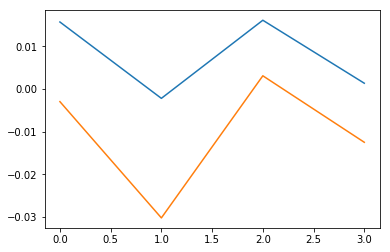

In [780]:
# shape = (samples, latent_samples, mean, latent_dim)
plt.plot(x_train_encoded[0,:,0,0])
plt.plot(x_train_encoded[0,:,0,1])

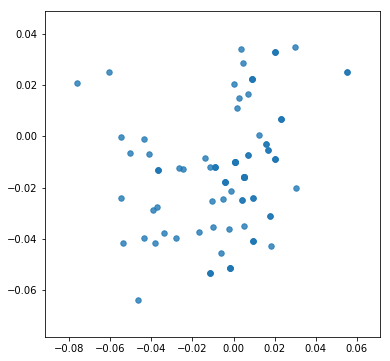

In [785]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:,0,0,0], x_train_encoded[:,0,0,1], alpha=0.8, s=30) # c=y_test, 

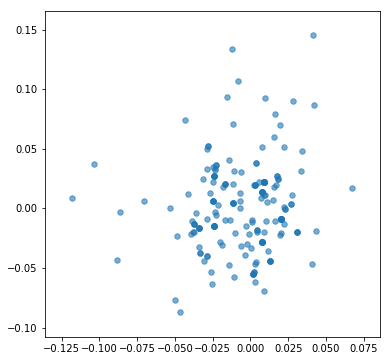

In [786]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,:,0,0], x_test_encoded[:,:,0,1], alpha=0.6, s=30) # , c=y_test
# plt.colorbar()

In [787]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

ValueError: Input 0 is incompatible with layer time_distributed_98: expected ndim=3, found ndim=2

In [771]:
# x_decoded[0].reshape(150,3)

In [772]:
x_train.shape

(450, 40, 9, 1)

In [773]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size, latent_dim,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

NameError: name 'generator' is not defined

In [774]:
min_y2 = max_y
plot.latent(generator, batch_size, latent_dim,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)

NameError: name 'generator' is not defined